# Imports & Setups

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Model & Train & Evaluate Function


Without BatchNorm

 Run: Dropout=0.1, BN=False 
Epoch 1/5 | Loss: 175.712 | Train Acc: 0.9426
Epoch 2/5 | Loss: 49.995 | Train Acc: 0.9839
Epoch 3/5 | Loss: 35.853 | Train Acc: 0.9879
Epoch 4/5 | Loss: 27.409 | Train Acc: 0.9905
Epoch 5/5 | Loss: 20.994 | Train Acc: 0.9928

Test Accuracy = 0.9894


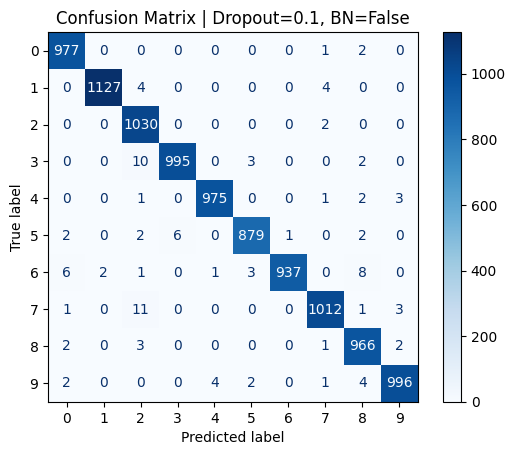


 Run: Dropout=0.3, BN=False 
Epoch 1/5 | Loss: 197.157 | Train Acc: 0.9350
Epoch 2/5 | Loss: 65.073 | Train Acc: 0.9786
Epoch 3/5 | Loss: 47.949 | Train Acc: 0.9841
Epoch 4/5 | Loss: 37.903 | Train Acc: 0.9874
Epoch 5/5 | Loss: 31.638 | Train Acc: 0.9895

Test Accuracy = 0.9911


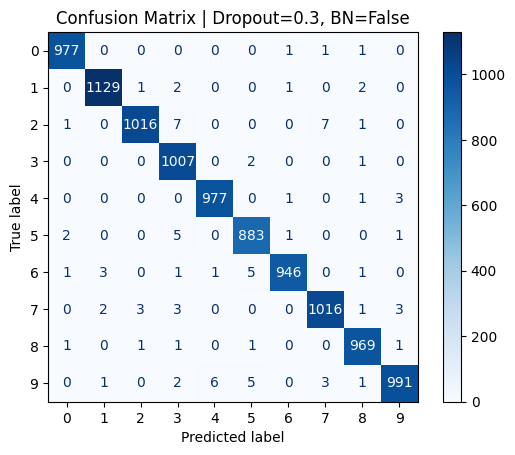


 Run: Dropout=0.5, BN=False 
Epoch 1/5 | Loss: 239.888 | Train Acc: 0.9218
Epoch 2/5 | Loss: 88.922 | Train Acc: 0.9723
Epoch 3/5 | Loss: 67.014 | Train Acc: 0.9784
Epoch 4/5 | Loss: 54.594 | Train Acc: 0.9821
Epoch 5/5 | Loss: 47.197 | Train Acc: 0.9845

Test Accuracy = 0.9913


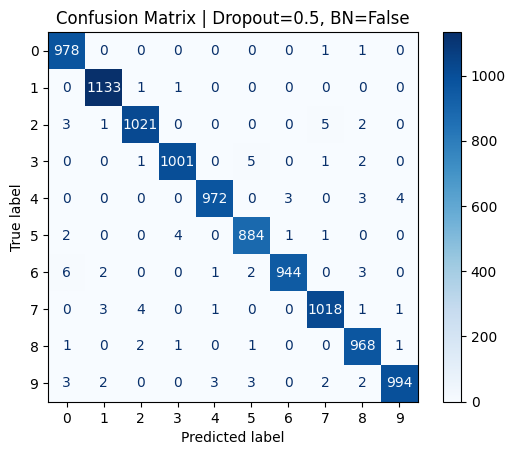


 Run: Dropout=0.7, BN=False 
Epoch 1/5 | Loss: 412.013 | Train Acc: 0.8591
Epoch 2/5 | Loss: 193.505 | Train Acc: 0.9343
Epoch 3/5 | Loss: 153.583 | Train Acc: 0.9468
Epoch 4/5 | Loss: 127.081 | Train Acc: 0.9574
Epoch 5/5 | Loss: 115.456 | Train Acc: 0.9599

Test Accuracy = 0.9895


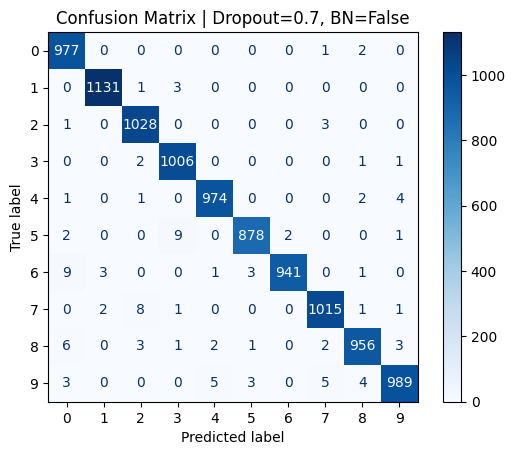


With BatchNorm

 Run: Dropout=0.1, BN=True 
Epoch 1/5 | Loss: 103.144 | Train Acc: 0.9735
Epoch 2/5 | Loss: 36.154 | Train Acc: 0.9885
Epoch 3/5 | Loss: 25.329 | Train Acc: 0.9918
Epoch 4/5 | Loss: 19.523 | Train Acc: 0.9937
Epoch 5/5 | Loss: 14.803 | Train Acc: 0.9952

Test Accuracy = 0.9898


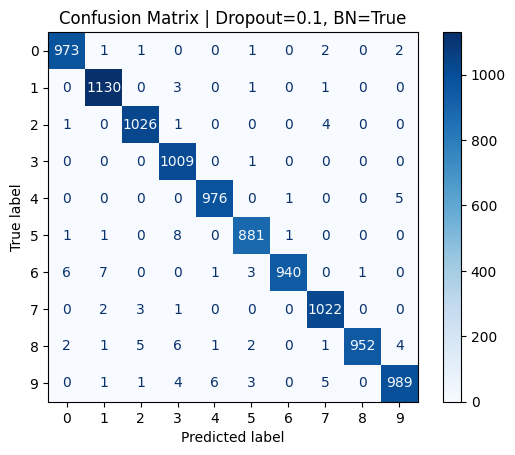


 Run: Dropout=0.3, BN=True 
Epoch 1/5 | Loss: 113.289 | Train Acc: 0.9709
Epoch 2/5 | Loss: 43.528 | Train Acc: 0.9859
Epoch 3/5 | Loss: 32.340 | Train Acc: 0.9892
Epoch 4/5 | Loss: 25.821 | Train Acc: 0.9915
Epoch 5/5 | Loss: 19.866 | Train Acc: 0.9934

Test Accuracy = 0.9926


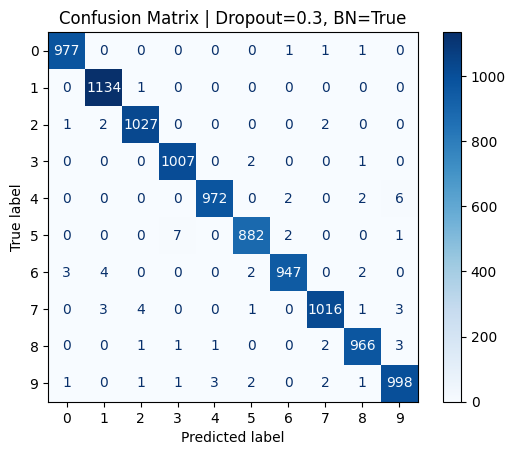


 Run: Dropout=0.5, BN=True 
Epoch 1/5 | Loss: 143.101 | Train Acc: 0.9636
Epoch 2/5 | Loss: 57.928 | Train Acc: 0.9814
Epoch 3/5 | Loss: 44.056 | Train Acc: 0.9861
Epoch 4/5 | Loss: 35.672 | Train Acc: 0.9884
Epoch 5/5 | Loss: 30.179 | Train Acc: 0.9896

Test Accuracy = 0.9913


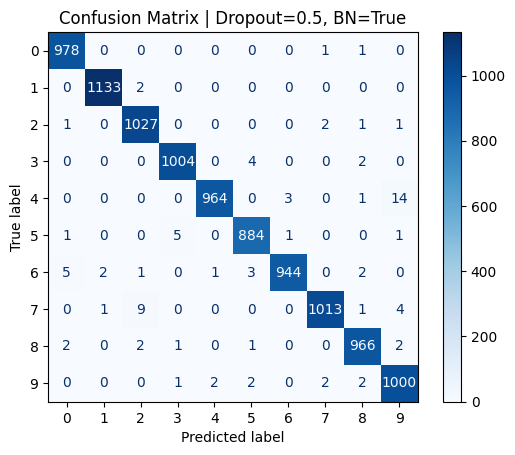


 Run: Dropout=0.7, BN=True 
Epoch 1/5 | Loss: 198.930 | Train Acc: 0.9479
Epoch 2/5 | Loss: 88.286 | Train Acc: 0.9730
Epoch 3/5 | Loss: 72.264 | Train Acc: 0.9787
Epoch 4/5 | Loss: 58.256 | Train Acc: 0.9817
Epoch 5/5 | Loss: 50.381 | Train Acc: 0.9841

Test Accuracy = 0.9931


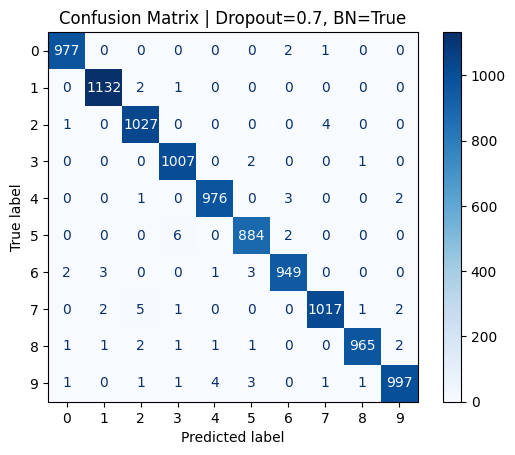

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# CNN Model
class CNNModel(nn.Module):
    def __init__(self, dropout_rate=0.5, use_batchnorm=False):
        super(CNNModel, self).__init__()

        self.use_batchnorm = use_batchnorm

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if use_batchnorm else nn.Identity()

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) if use_batchnorm else nn.Identity()

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)   # Correct shape
        self.bn_fc = nn.BatchNorm1d(128) if use_batchnorm else nn.Identity()

        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.bn_fc(self.fc1(x))))
        x = self.fc2(x)
        return x


# Training + Testing Function
def train_and_evaluate(dropout_rate=0.0, use_batchnorm=False, epochs=5, lr=0.001):

    model = CNNModel(dropout_rate=dropout_rate, use_batchnorm=use_batchnorm).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training
    for epoch in range(epochs):
        model.train()
        correct, total_loss = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        total_samples = len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.3f} | Train Acc: {correct/total_samples:.4f}")

    # Testing
    model.eval()
    correct, all_pred, all_lbl = 0, [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)

            correct += (preds == labels).sum().item()
            all_pred.extend(preds.cpu().numpy())
            all_lbl.extend(labels.cpu().numpy())

    acc = correct / len(test_loader.dataset)
    print(f"\nTest Accuracy = {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_lbl, all_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix | Dropout={dropout_rate}, BN={use_batchnorm}")
    plt.show()
    plt.pause(0.1)
    plt.close('all')

    return acc


# ==== Run Experiment ====
dropout_rates = [0.1, 0.3, 0.5, 0.7]

print("\nWithout BatchNorm")
for r in dropout_rates:
    print(f"\n Run: Dropout={r}, BN=False ")
    train_and_evaluate(dropout_rate=r, use_batchnorm=False, epochs=5)

print("\nWith BatchNorm")
for r in dropout_rates:
    print(f"\n Run: Dropout={r}, BN=True ")
    train_and_evaluate(dropout_rate=r, use_batchnorm=True, epochs=5)
